In [241]:
%matplotlib inline
import apache_log_parser
import pandas as pd
from textwrap import indent
import matplotlib.pyplot as plt
import glob
import datetime
import pprint
dir = r"C:\Users\htaka\Desktop\\"

''

In [3]:
ssl_request_parser = "%t %h %{SSL_PROTOCOL}x %{SSL_CIPHER}x \"%r\" %b"
ssl_response_parser = "%h %l %u %t \"%r\" %>s %b"
def read_apache_log(path, parse_pattern):
    parser = apache_log_parser.make_parser(parse_pattern)
    log = []
    with open(path, 'r', encoding='utf-8') as f:
        for i in f:
            try:
                parsed_log = parser(i)
                log.append(parsed_log)
            except: # apache_log_parser.LineDoesntMatchException
                print('exception')
                print(i)
                continue
    df = pd.DataFrame(log)
    return df

In [90]:
# get the log path
path_search = dir + "Desktop\httpd_log\*"
file_path = glob.glob(path_search)
li_access_log = []
li_error_log = []
li_ssl_access_log = []
li_ssl_request_log = []
li_ssl_error_log = []
for i in file_path:
    if i.split('\\')[-1].startswith('ssl_error-log'):
        li_ssl_error_log.append(i)
    elif i.split('\\')[-1].startswith('ssl_request_log'):
        li_ssl_request_log.append(i)
    elif i.split('\\')[-1].startswith('ssl_access_log'):
        li_ssl_access_log.append(i)
    elif i.split('\\')[-1].startswith('error_log'):
        li_error_log.append(i)

In [4]:
df_access_log_base = read_apache_log(r"C:\Users\htaka\Desktop\httpd_log\ssl_access_log_03-07_del.txt", "%h %l %u %t \"%r\" %>s %b")

exception
104.166.127.130 - - [13/Mar/2023:13:57:49 +0900] "GET //https:evil.com HTTP/1.1" 404 118

exception
104.166.127.130 - - [13/Mar/2023:20:08:38 +0900] "GET //https:evil.com HTTP/1.1" 404 118



In [237]:
df_access_log = df_access_log_base[(df_access_log_base['status'] == '200')\
                              # & (df_access_log_base['request_url'] != '/')\
                              & (df_access_log_base['request_url'] != '')\
                              & (~df_access_log_base['request_url'].str.contains('apache|woff|css|gif|icon|.png|.jpg'))]

<Figure size 640x480 with 0 Axes>

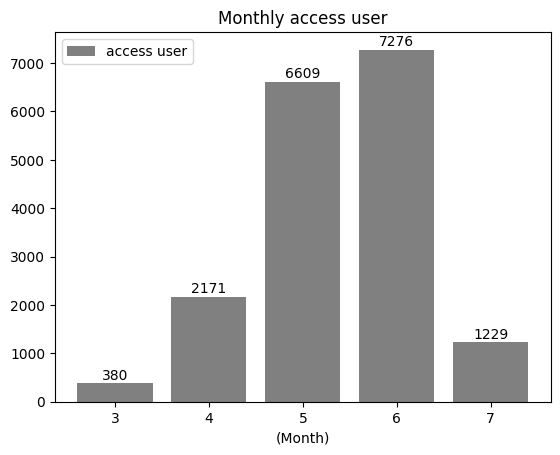

In [207]:
# Monthly access user
# get access user per month
x_list = []
y_list = []
df_access_log_date = df_access_log[df_access_log['time_received_datetimeobj'] >= datetime.datetime(2023,3,1)][['time_received_datetimeobj', 'remote_host']].set_index('time_received_datetimeobj')
for index, value in df_access_log_date.resample('M').apply(list).iterrows():
    x_list.append(index.month)
    y_list.append(len(set(value['remote_host'])))

plt.figure()
fig, ax = plt.subplots()
ax.bar([i for i in range(len(x_list))], y_list, color='gray', label='access user')
for x, y in zip([i for i in range(len(x_list))], y_list):
    ax.text(x,y+80, str(y), ha='center')
ax.set_xlabel('(Month)')
ax.set_title('Monthly access user')
plt.xticks([i for i in range(len(x_list))], labels=x_list)
plt.legend()
plt.savefig(r"C:\Users\htaka\Desktop\httpd_log\monthly_access_user.png")

<Figure size 640x480 with 0 Axes>

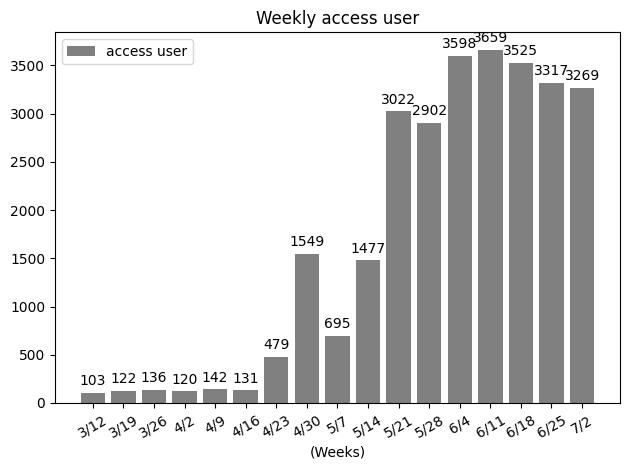

In [218]:
# Monthly access user
# get access user per month
x_list = []
y_list = []
df_access_log_date = df_access_log[df_access_log['time_received_datetimeobj'] >= datetime.datetime(2023,3,1)][['time_received_datetimeobj', 'remote_host']].set_index('time_received_datetimeobj')
for index, value in df_access_log_date.resample('W').apply(list).iterrows():
    x_list.append(str(index.month)+'/' + str(index.day))
    y_list.append(len(set(value['remote_host'])))

plt.figure()
fig, ax = plt.subplots()
ax.bar([i for i in range(len(x_list))], y_list, color='gray', label='access user')
for x, y in zip([i for i in range(len(x_list))], y_list):
    ax.text(x,y+80, str(y), ha='center')
ax.set_xlabel('(Weeks)')
ax.set_title('Weekly access user')
plt.xticks([i for i in range(len(x_list))], labels=x_list, rotation=30)
plt.legend()
plt.tight_layout()
plt.savefig(r"C:\Users\htaka\Desktop\httpd_log\weekly_access_user.png")

In [219]:
print('期間中の総ユーザ数 : {}'.format(len(set(df_access_log_date.resample('Y').apply(list)['remote_host'].to_list()[0]))))

期間中の総ユーザ数 : 12697


期間中月単位で何回アクセスしているか


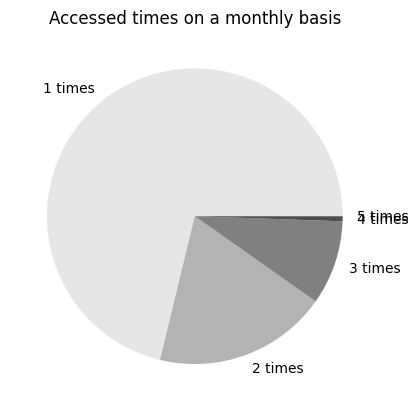

In [221]:
# 2つの集合にのみ共通する要素をカウントする関数
plt.figure()
def count_common_elements(tuples, count):
    count_dict = {}
    for t in tuples:
        for e in t:
            if e not in count_dict:
                count_dict[e] = 1
            else:
                count_dict[e] += 1
    return sum(v == count for v in count_dict.values())
tuples = []
for index, value in df_access_log_date.resample('M').apply(list).iterrows():
    tuples.append(set(value['remote_host']))
print('期間中月単位で何回アクセスしているか')
# ほとんどが1回のみアクセスしているユーザ、定期利用している人は思ったより少ない。
colors = ["0.9", "0.7", "0.5", "0.3", "0.1"]
li_pie = []
for i in range(1, len(tuples) + 1):
    li_pie.append(count_common_elements(tuples, i))
plt.pie(li_pie, labels=[str(i) + ' times' for i in range(1,len(tuples) + 1)], colors=colors, pctdistance=0.8)
plt.title("Accessed times on a monthly basis")
plt.savefig(r"C:\Users\htaka\Desktop\httpd_log\accessed_times_monthly.png",  bbox_inches='tight', pad_inches=0)

期間中週単位で何回アクセスしているか


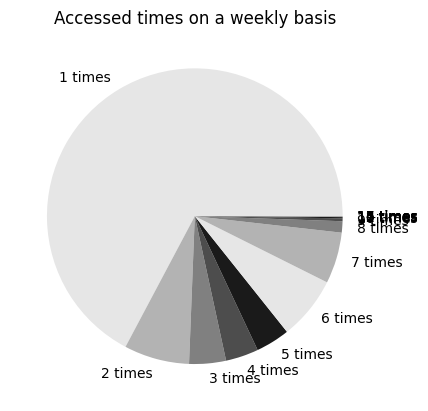

In [220]:
plt.figure()
tuples = []
for index, value in df_access_log_date.resample('W').apply(list).iterrows():
    tuples.append(set(value['remote_host']))
print('期間中週単位で何回アクセスしているか')
# ほとんどが1回のみアクセスしているユーザ、定期利用している人は思ったより少ない。
colors = ["0.9", "0.7", "0.5", "0.3", "0.1"]
li_pie = []
for i in range(1, len(tuples) + 1):
    li_pie.append(count_common_elements(tuples, i))
plt.pie(li_pie, labels=[str(i) + ' times' for i in range(1,len(tuples) + 1)], colors=colors)
plt.title("Accessed times on a weekly basis")
plt.savefig(r"C:\Users\htaka\Desktop\httpd_log\accessed_times_weekly.png",  bbox_inches='tight', pad_inches=0)

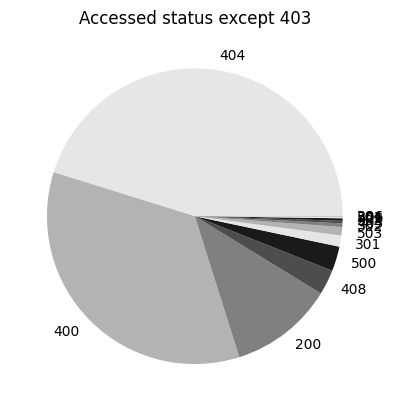

In [148]:
# status except 403
plt.figure()
plt.pie(df_access_log_base['status'].value_counts()[1:], labels=df_access_log_base['status'].unique()[1:], colors=colors)
plt.title('Accessed status except 403')
plt.show()

In [99]:
def access_time_chart(df):
    li = {'1':0, '2':0, '3':0, '4':0, '5':0, '6':0, '7':0, '8':0, '9':0, '10':0, '11':0, '12':0,\
        '13':0, '14':0, '15':0, '16':0, '17':0, '18':0, '19':0, '20':0, '21':0, '22':0, '23':0, '0':0}
    # classify the accessed hour with dictionaly
    for i in df['time_received_datetimeobj']:
        hour = i.hour
        if hour == 1:
            li['1'] += 1
        elif hour == 2:
            li['2'] += 1
        elif hour == 3:
            li['3'] += 1
        elif hour == 4:
            li['4'] += 1
        elif hour == 5:
            li['5'] += 1
        elif hour == 6:
            li['6'] += 1
        elif hour == 7:
            li['7'] += 1
        elif hour == 8:
            li['8'] += 1
        elif hour == 9:
            li['9'] += 1
        elif hour == 10:
            li['10'] += 1
        elif hour == 11:
            li['11'] += 1
        elif hour == 12:
            li['12'] += 1
        elif hour == 13:
            li['13'] += 1
        elif hour == 14:
            li['14'] += 1
        elif hour == 15:
            li['15'] += 1
        elif hour == 16:
            li['16'] += 1
        elif hour == 17:
            li['17'] += 1
        elif hour == 18:
            li['18'] += 1
        elif hour == 19:
            li['19'] += 1
        elif hour == 20:
            li['20'] += 1
        elif hour == 21:
            li['21'] += 1
        elif hour == 22:
            li['22'] += 1
        elif hour == 23:
            li['23'] += 1
        elif hour == 24:
            li['0'] += 1
    access = list(li.values())[::-1]
    labels = list(li.keys())[::-1]
    return access, labels

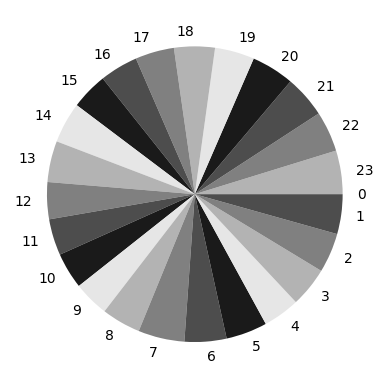

In [145]:
# ほぼ均等なので、botがまだ混入している可能性？
plt.figure()
access, labels = access_time_chart(df_access_log)
plt.pie(access, labels=labels, colors=colors)
plt.show()

In [240]:
# アクセス数の多いページ
df_access_log.value_counts('request_url').head(20).to_csv(r"C:\Users\htaka\Desktop\httpd_log\request_count.csv")